### Clean up the nulls and any 0 values before continuing.

#### Issues
1. There are many null values in cost and cost_per_watt.  Get rid of these because they don't add any value.
1. There are 35k installations with null values for installation type. 
1. Important variables need sanity checking.
    How many have size_kw * cost_per_watt - cost != 0

##### Defer to next step
1. There are outlying values in the residential size_kw, cost, cost_per_watt.  
1. Then I want to check all of the above on the commercial installs.


In [1]:
# %load ../pycode/setup.py
# set up
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

def ecdf(data):
    '''Compute ECDF for a one-dimensional array of measurements.'''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n + 1) / n
    return x, y

def min015099max(series, minmax=False):
    ''' return list of [ min, 1%, median, 99%, max ] series values '''
    vals = list(np.percentile(series, [1.0, 50.0, 99.0]))
    if minmax: 
        vals.insert(0, series.min())
        vals.append(series.max())    
    return vals
# ss = np.arange(1, 101)
# min_1_50_99_max(ss)             

def mid98(series):
    '''  return middle 98% of series '''
    bounds = series.quantile([0.01, 0.99])
    return(series[(series > bounds.values[0]) & (series < bounds.values[1])])

# ss = np.arange(1, 101)
# min_1_50_99_max(ss)


In [2]:
# %load ../pycode/side_by_side.py
from pandas.io.formats.printing import adjoin

def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print(adjoin(space, *reprs))

# tdf = pd.DataFrame(np.arange(12).reshape(4, 3), index=list ('abcd'), columns=list('wxy'))

# udf = pd.DataFrame(np.arange(100, 112).reshape(4, 3), index=list ('abcd'), columns=list('wxy'))

# side_by_side(tdf, udf)

In [3]:
# load data with install_type cleaned up and replaced by i_type
dfLive = pd.read_csv('../local/data/20180101.csv', index_col='date_installed', 
                     parse_dates=True,  dtype={'zipcode' : np.object})

In [4]:
dfLive.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1002025 entries, 2004-01-01 to 2015-12-31
Data columns (total 18 columns):
cost_per_watt    745516 non-null float64
cost             745629 non-null float64
size_kw          1002025 non-null float64
state            1002025 non-null object
zipcode          1002025 non-null object
city             788849 non-null object
county           980790 non-null object
new_constr       27098 non-null float64
tracking         1920 non-null float64
third_party      306989 non-null float64
appraised        223431 non-null object
incentive        788415 non-null object
utility          783186 non-null object
tech             580399 non-null object
model            580399 non-null object
installer        694390 non-null object
bipv             5252 non-null float64
i_type           966720 non-null object
dtypes: float64(7), object(11)
memory usage: 145.3+ MB


In [5]:
dfLive.describe()

,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,745516.000000,7.456290e+05,1.002025e+06,27098.0,1920.0,306989.0,5252.0
mean,5.864389,6.531153e+04,1.629462e+01,1.0,1.0,1.0,1.0
std,2.026492,4.952030e+05,8.891764e+02,0.0,0.0,0.0,0.0
min,0.000000,0.000000e+00,2.000000e-03,1.0,1.0,1.0,1.0
25%,4.565217,2.114000e+04,3.750000e+00,1.0,1.0,1.0,1.0
50%,5.500000,3.030132e+04,5.500000e+00,1.0,1.0,1.0,1.0
75%,7.050000,4.363560e+04,7.905000e+00,1.0,1.0,1.0,1.0
max,30.000000,1.522000e+08,7.373190e+05,1.0,1.0,1.0,1.0


In [6]:
dfLive.describe(include=np.object)

,state,zipcode,city,county,appraised,incentive,utility,tech,model,installer,i_type
count,1002025,1002025,788849,980790,223431,788415,783186,580399,580399,694390,966720
unique,52,13381,11152,1019,1,65,378,11,3263,10168,8
top,CA,93312,SAN DIEGO,Los Angeles,True,California Public Utilities Commission (Non-CS...,Pacific Gas & Electric Company,Poly,multiple matches,SolarCity,residential
freq,611709,3725,13681,80985,223431,260940,211222,350294,96843,167523,898183


In [7]:
dfLive.i_type.value_counts()

residential     898183
commercial       35950
unknown          19520
government        5702
nonprofit         4220
educational       2572
agricultural       349
utility            224
Name: i_type, dtype: int64

In [8]:
# drop any rows that don't have all of ['cost_per_watt', 'cost', 'size_kw']
thing = dfLive.dropna(subset=['cost_per_watt', 'cost', 'size_kw'], how='any')

In [51]:
thing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745362 entries, 0 to 745370
Data columns (total 19 columns):
date_installed    745362 non-null datetime64[ns]
cost_per_watt     745362 non-null float64
cost              745362 non-null float64
size_kw           745362 non-null float64
state             745362 non-null object
zipcode           745362 non-null object
city              552240 non-null object
county            732641 non-null object
new_constr        23813 non-null float64
tracking          1705 non-null float64
third_party       239541 non-null float64
appraised         146655 non-null object
incentive         552618 non-null object
utility           550246 non-null object
tech              421871 non-null object
model             421871 non-null object
installer         470553 non-null object
bipv              3897 non-null float64
i_type            715437 non-null object
dtypes: datetime64[ns](1), float64(7), object(11)
memory usage: 113.7+ MB


In [9]:
# compare 
dfLive.describe()

,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,745516.000000,7.456290e+05,1.002025e+06,27098.0,1920.0,306989.0,5252.0
mean,5.864389,6.531153e+04,1.629462e+01,1.0,1.0,1.0,1.0
std,2.026492,4.952030e+05,8.891764e+02,0.0,0.0,0.0,0.0
min,0.000000,0.000000e+00,2.000000e-03,1.0,1.0,1.0,1.0
25%,4.565217,2.114000e+04,3.750000e+00,1.0,1.0,1.0,1.0
50%,5.500000,3.030132e+04,5.500000e+00,1.0,1.0,1.0,1.0
75%,7.050000,4.363560e+04,7.905000e+00,1.0,1.0,1.0,1.0
max,30.000000,1.522000e+08,7.373190e+05,1.0,1.0,1.0,1.0


In [10]:
# compare
thing.describe()

,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,745371.000000,7.453710e+05,745371.000000,23813.0,1705.0,239541.0,3897.0
mean,5.863977,6.524818e+04,12.470437,1.0,1.0,1.0,1.0
std,2.026111,4.898935e+05,112.741907,0.0,0.0,0.0,0.0
min,0.000000,0.000000e+00,0.010000,1.0,1.0,1.0,1.0
25%,4.565018,2.115000e+04,3.780000,1.0,1.0,1.0,1.0
50%,5.500000,3.031500e+04,5.550000,1.0,1.0,1.0,1.0
75%,7.050000,4.364647e+04,7.980000,1.0,1.0,1.0,1.0
max,30.000000,1.522000e+08,34000.000000,1.0,1.0,1.0,1.0


#### Okay, dropped 250k rows.
All rows should have no null values for cpw, cost, size_kw

In [11]:
thing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745371 entries, 2004-01-01 to 2015-12-31
Data columns (total 18 columns):
cost_per_watt    745371 non-null float64
cost             745371 non-null float64
size_kw          745371 non-null float64
state            745371 non-null object
zipcode          745371 non-null object
city             552242 non-null object
county           732647 non-null object
new_constr       23813 non-null float64
tracking         1705 non-null float64
third_party      239541 non-null float64
appraised        146655 non-null object
incentive        552618 non-null object
utility          550246 non-null object
tech             421871 non-null object
model            421871 non-null object
installer        470554 non-null object
bipv             3897 non-null float64
i_type           715446 non-null object
dtypes: float64(7), object(11)
memory usage: 108.0+ MB


#### Looks good; reassign dfLive

In [12]:
dfLive = thing

#### Now look at the null install type entrys; there are 40+k of them....

In [13]:
iTypeNull = dfLive[dfLive.i_type.isnull()]

In [14]:
iTypeNull.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29925 entries, 2004-01-01 to 2015-12-31
Data columns (total 18 columns):
cost_per_watt    29925 non-null float64
cost             29925 non-null float64
size_kw          29925 non-null float64
state            29925 non-null object
zipcode          29925 non-null object
city             26030 non-null object
county           29703 non-null object
new_constr       2575 non-null float64
tracking         70 non-null float64
third_party      205 non-null float64
appraised        604 non-null object
incentive        27093 non-null object
utility          27037 non-null object
tech             13435 non-null object
model            13435 non-null object
installer        12579 non-null object
bipv             771 non-null float64
i_type           0 non-null object
dtypes: float64(7), object(11)
memory usage: 4.3+ MB


#### These rows are a bit strange.
Max is obviously pretty out there.  $100M is a lot of money.


Mean and median are off by factor of 2.  And they're pretty expensive compared to the larger data set. 


Timing (see groupby) is a bit funny.  I could fold them into i_type unknown.  First check their sensibility.  Looks pretty good.  Don't throw away yet.  They won't do any harm.

In [15]:
iTypeNull.describe()

,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,29925.000000,2.992500e+04,29925.000000,2575.0,70.0,205.0,771.0
mean,7.571928,7.010113e+04,10.026701,1.0,1.0,1.0,1.0
std,1.956078,6.529559e+05,93.699826,0.0,0.0,0.0,0.0
min,0.824386,7.640000e+02,0.050000,1.0,1.0,1.0,1.0
25%,6.664394,2.128459e+04,2.960000,1.0,1.0,1.0,1.0
50%,7.570000,3.212706e+04,4.320000,1.0,1.0,1.0,1.0
75%,8.451552,4.863860e+04,6.800000,1.0,1.0,1.0,1.0
max,29.598039,1.000000e+08,14200.000000,1.0,1.0,1.0,1.0


In [16]:
# how are they distributed over time?
iTypeNull.groupby(iTypeNull.index.map(lambda x: x.year)).size()

date_installed
2004    4824
2005    4143
2006    6521
2007    6555
2008    1704
2009    1549
2010    1039
2011     423
2012     695
2013     696
2014     810
2015     966
dtype: int64

In [17]:
# This value should be near 1.0
shouldBe1 = iTypeNull.cost_per_watt * 1000 * iTypeNull.size_kw/iTypeNull.cost

In [18]:
# are they?  yes, very much so.
shouldBe1.describe()

count    29925.000000
mean         0.999998
std          0.000326
min          0.946092
25%          1.000000
50%          1.000000
75%          1.000000
max          1.001571
dtype: float64

#### Sanity check all values in cost/watt, cost and size.

In [19]:
# start by checking sense (now that I know null install types won't throw it off) of all rows.
shouldBe1 = dfLive.cost_per_watt * 1000 * dfLive.size_kw/dfLive.cost

In [20]:
# get stats
shouldBe1.describe()

count    7.453700e+05
mean              inf
std               NaN
min      7.413729e-01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max               inf
dtype: float64

#### there are some bad data in there


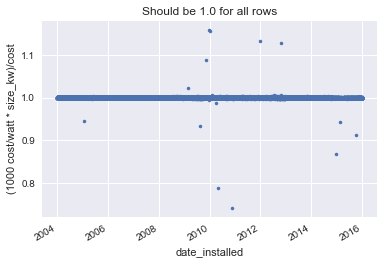

In [21]:
shouldBe1.plot(marker='.',linestyle='none')
plt.ylabel( '(1000 cost/watt * size_kw)/cost')
plt.title('Should be 1.0 for all rows');

In [22]:
# how many are off by 10% or more
(abs(dfLive.cost_per_watt * 1000 * dfLive.size_kw/dfLive.cost - 1) > 0.1).sum()

8

In [23]:
badGuys= dfLive.loc[(abs(dfLive.cost_per_watt * 1000 * dfLive.size_kw/dfLive.cost - 1) > 0.1)]

In [24]:
badGuys.index

DatetimeIndex(['2009-12-19', '2010-01-09', '2010-05-01', '2010-11-19',
               '2011-12-20', '2012-10-25', '2013-03-24', '2014-12-31'],
              dtype='datetime64[ns]', name='date_installed', freq=None)

In [25]:
# I need to reindex to get rid of the bad values
thing = dfLive.reset_index()

In [26]:
# find bad ones in the newly indexed df
badGuys= thing.loc[(abs(thing.cost_per_watt * 1000 * thing.size_kw/thing.cost - 1) > 0.1)]

In [27]:
# let's see
badGuys

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
144088,2009-12-19,5.90,55000.0,10.800,TX,75706,NaN,Smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
147691,2010-01-09,6.30,58808.0,10.800,TX,75758,NaN,Henderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
169136,2010-05-01,6.10,3095.0,0.400,NH,03750,NaN,Grafton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
211208,2010-11-19,3.33,2695000.0,600.000,MN,55403,NaN,Hennepin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,commercial
295231,2011-12-20,4.00,120000000.0,34000.000,TX,78653,NaN,Travis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,utility
382718,2012-10-25,4.05,69190.0,19.285,IN,47630,NaN,Warrick,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Morton Solar, LLC",NaN,residential
424477,2013-03-24,1.00,0.0,3.430,CO,80130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential
557277,2014-12-31,5.91,1300000.0,191.000,CA,91605,North Hollywood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,commercial


In [28]:
# where are they?
badGuys.index

Int64Index([144088, 147691, 169136, 211208, 295231, 382718, 424477, 557277], dtype='int64')

In [29]:
# drop marginal values
thing.drop(badGuys.index, inplace=True)

In [30]:
# all gone
(abs(thing.cost_per_watt * 1000 * thing.size_kw/thing.cost - 1) > 0.1).sum()

0

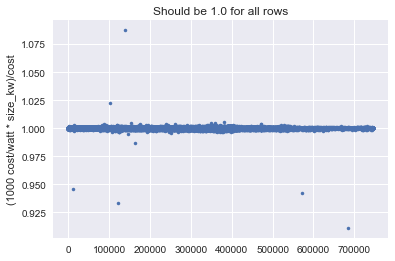

In [31]:
(thing.cost_per_watt * 1000 * thing.size_kw/thing.cost).plot(marker='.',linestyle='none')
plt.ylabel( '(1000 cost/watt * size_kw)/cost')
plt.title('Should be 1.0 for all rows');

In [32]:
# look at stats now
(thing.cost_per_watt * 1000 * thing.size_kw/thing.cost).describe()

count    745362.000000
mean          0.999991
std           0.000301
min           0.911127
25%           1.000000
50%           1.000000
75%           1.000000
max           1.087374
dtype: float64

### before continuing, check for zero values in important variables

Okay, one row has 0 cost and cost_per_watt.  Let's get rid of it.

In [33]:
# check cost; 1 bad row
thing.loc[thing.cost == 0]

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
584522,2015-04-09,0.0,0.0,12.3,MN,56435,Pontoria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential


In [34]:
# check cost_per_watt; the same row is bad
thing.loc[thing.cost_per_watt == 0]

,date_installed,cost_per_watt,cost,size_kw,state,zipcode,city,county,new_constr,tracking,third_party,appraised,incentive,utility,tech,model,installer,bipv,i_type
584522,2015-04-09,0.0,0.0,12.3,MN,56435,Pontoria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,residential


In [35]:
# check size_kw; all ok
thing.loc[thing.size_kw == 0].size

0

In [36]:
# get rid of bad guy
thing.drop(thing.loc[thing.cost == 0].index, inplace=True)

In [37]:
# check that it's gone
thing.loc[thing.cost == 0].size

0

#### Looking good; reassign dfLive

In [38]:
dfLive = thing

### Now let's look at distribution of residential install variable with some useless data gone.

In [39]:
resMask = (dfLive.i_type == 'residential')

In [40]:
dfLive.loc[resMask].describe()

,cost_per_watt,cost,size_kw,new_constr,tracking,third_party,bipv
count,664982.000000,6.649820e+05,664982.000000,20997.0,1262.0,234924.0,2979.0
mean,5.765620,3.378477e+04,6.153678,1.0,1.0,1.0,1.0
std,1.960203,3.162304e+04,7.070553,0.0,0.0,0.0,0.0
min,0.750000,2.270000e+02,0.050000,1.0,1.0,1.0,1.0
25%,4.519231,2.071178e+04,3.760000,1.0,1.0,1.0,1.0
50%,5.370000,2.940000e+04,5.460000,1.0,1.0,1.0,1.0
75%,6.880000,4.110000e+04,7.650000,1.0,1.0,1.0,1.0
max,29.825243,3.940000e+06,1989.520000,1.0,1.0,1.0,1.0


In [41]:
# this tells me I have no null sizes
dfLive.loc[resMask].size_kw.isnull().sum()

0

In [42]:
# no null costs
dfLive.loc[resMask].cost.isnull().sum()

0

In [43]:
# no null cpw
dfLive.loc[resMask].cost_per_watt.isnull().sum()

0

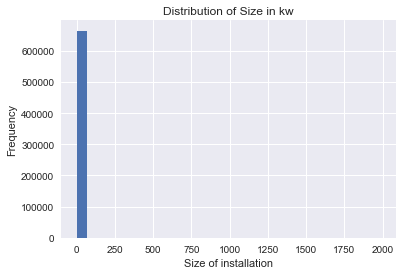

In [44]:
dfLive.loc[resMask].size_kw.plot(kind='hist', bins=30)
plt.xlabel('Size of installation')
plt.ylabel('Frequency')
plt.title('Distribution of Size in kw');

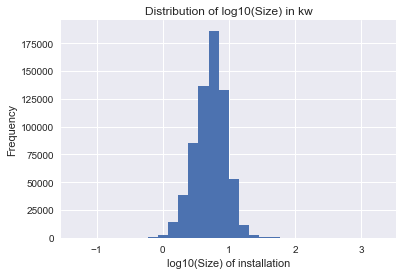

In [45]:
np.log10(dfLive.loc[resMask].size_kw).plot(kind='hist', bins=30)
plt.xlabel('log10(Size) of installation')
plt.ylabel('Frequency')
plt.title('Distribution of log10(Size) in kw');

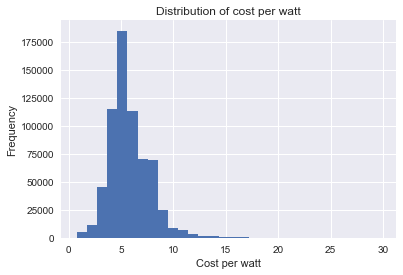

In [46]:
dfLive.loc[resMask].cost_per_watt.plot(kind='hist', bins=30)
plt.xlabel('Cost per watt')
plt.ylabel('Frequency')
plt.title('Distribution of cost per watt');

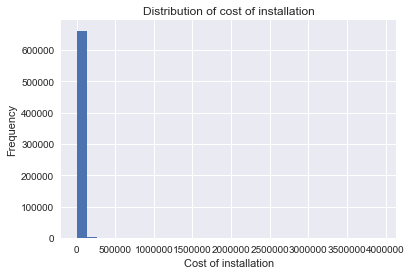

In [47]:
dfLive.loc[resMask].cost.plot(kind='hist', bins=30)
plt.xlabel('Cost of installation')
plt.ylabel('Frequency')
plt.title('Distribution of cost of installation');

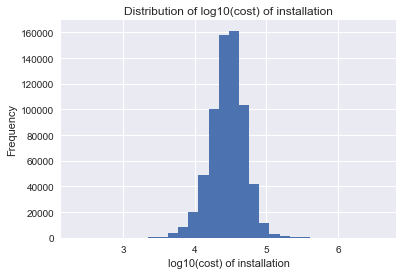

In [48]:
np.log10(dfLive.loc[resMask].cost).plot(kind='hist', bins=30)
plt.xlabel('log10(cost) of installation')
plt.ylabel('Frequency')
plt.title('Distribution of log10(cost) of installation');

In [49]:
# save this data...
dfLive.to_csv('../local/data/20180105')

In [50]:
dfLive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745362 entries, 0 to 745370
Data columns (total 19 columns):
date_installed    745362 non-null datetime64[ns]
cost_per_watt     745362 non-null float64
cost              745362 non-null float64
size_kw           745362 non-null float64
state             745362 non-null object
zipcode           745362 non-null object
city              552240 non-null object
county            732641 non-null object
new_constr        23813 non-null float64
tracking          1705 non-null float64
third_party       239541 non-null float64
appraised         146655 non-null object
incentive         552618 non-null object
utility           550246 non-null object
tech              421871 non-null object
model             421871 non-null object
installer         470553 non-null object
bipv              3897 non-null float64
i_type            715437 non-null object
dtypes: datetime64[ns](1), float64(7), object(11)
memory usage: 113.7+ MB


### Stopping here.  Continue with checking outlying values in cost, cost/watt, size_kw